In [1]:
import os
drive_dir = '/content/drive/MyDrive/ITMO_HW/GenSpeech/HW1'
os.chdir(drive_dir)

In [2]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt

## Testing LogMelFilterBanks

In [ ]:
signal, sr = torchaudio.load('/content/drive/MyDrive/ITMO_HW/GenSpeech/HW1/audio.wav')

In [ ]:
%load_ext autoreload
%autoreload 2
from melbanks import LogMelFilterBanks
melspec = torchaudio.transforms.MelSpectrogram(
    hop_length=160,
    n_mels=80
)(signal)
logmelbanks = LogMelFilterBanks()(signal)

assert torch.log(melspec + 1e-6).shape == logmelbanks.shape
assert torch.allclose(torch.log(melspec + 1e-6), logmelbanks)

Figure saved to ./melspec_comparison.png


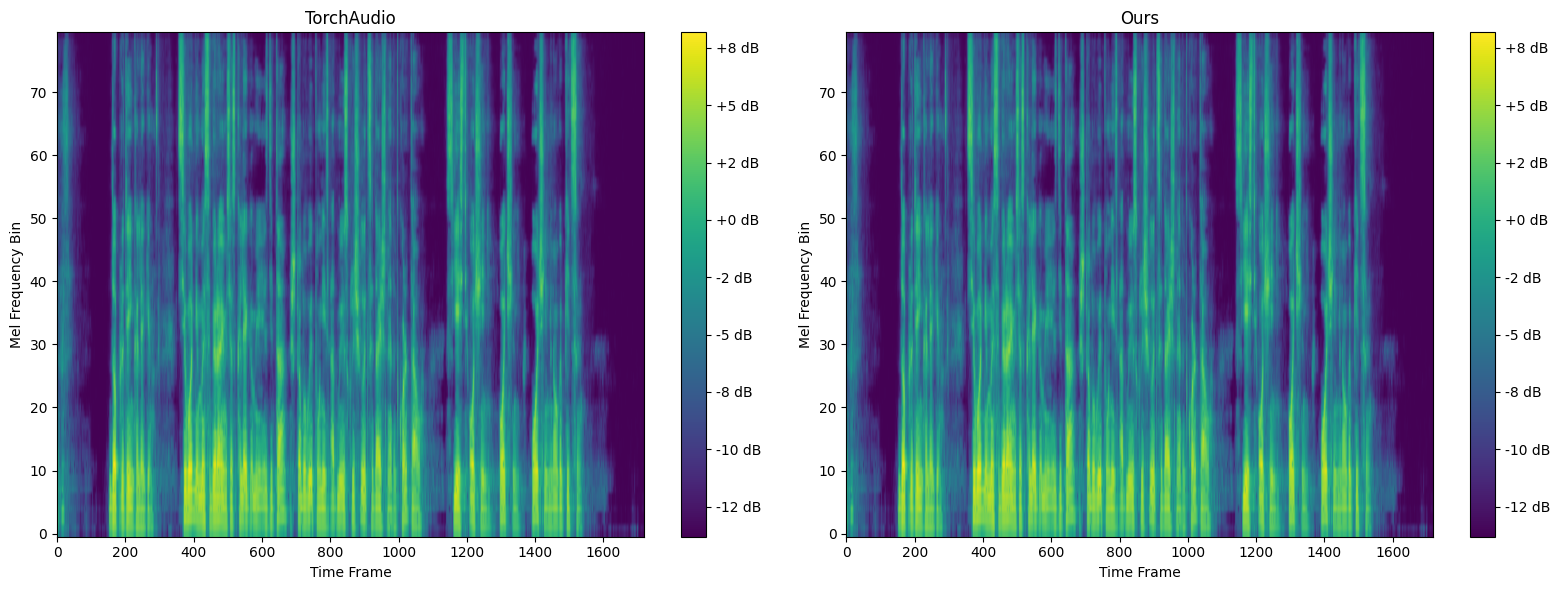

In [ ]:
torch_log_melspec = torch.log(melspec + 1e-6)

torch_log_melspec_np = torch_log_melspec.squeeze().numpy()
custom_log_melspec_np = logmelbanks.squeeze().numpy()

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.imshow(torch_log_melspec_np, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('TorchAudio')
plt.xlabel('Time Frame')
plt.ylabel('Mel Frequency Bin')

plt.subplot(1, 2, 2)
plt.imshow(custom_log_melspec_np, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Ours')
plt.xlabel('Time Frame')
plt.ylabel('Mel Frequency Bin')


plt.tight_layout()

save_dir = './'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'melspec_comparison.png')

plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to {save_path}")

plt.show()

## Training on SpeechCommands

In [ ]:
!pip install thop

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS
import os
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import numpy as np
from thop import profile
from melbanks import LogMelFilterBanks

Data Handling

In [ ]:
class BinarySubsetSC(Dataset):
    def __init__(self, subset, device=None):
        self.device = device
        self.sc_dataset = SubsetSC(subset)
        self.data_points = []
        for i in range(len(self.sc_dataset)):
            waveform, sample_rate, label, speaker_id, utterance_number = self.sc_dataset[i]
            if label in ["yes", "no"]:
                self.data_points.append((waveform, sample_rate, label, speaker_id, utterance_number))

        print(f"Number of '{subset}' examples: {len(self.data_points)}")

    def __len__(self):
        return len(self.data_points)

    def __getitem__(self, idx):
        waveform, sample_rate, label, speaker_id, utterance_number = self.data_points[idx]
        binary_label = 1 if label == "yes" else 0

        return waveform, sample_rate, binary_label

class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("/content", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


def collate_fn(batch):
    waveforms = []
    labels = []

    for waveform, _, label in batch:
        waveforms.append(waveform)
        labels.append(label)

    waveforms = torch.nn.utils.rnn.pad_sequence(
        [waveform.squeeze(0) for waveform in waveforms],
        batch_first=True
    ).unsqueeze(1)

    labels = torch.tensor(labels, dtype=torch.float32)

    return waveforms, labels

Data init

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_set = BinarySubsetSC("training", device)
val_set = BinarySubsetSC("validation", device)
test_set = BinarySubsetSC("testing", device)

Using device: cuda
Number of 'training' examples: 6358
Number of 'validation' examples: 803
Number of 'testing' examples: 824


Setup

In [ ]:
os.makedirs('results', exist_ok=True)

class ExperimentTracker:
    def __init__(self, experiment_name):
        self.experiment_name = experiment_name
        self.train_losses = []
        self.val_accuracies = []
        self.epoch_times = []
        self.final_test_accuracy = None
        self.num_params = None
        self.flops = None
        self.avg_epoch_time = None
        self.n_mels = None
        self.groups = None

    def update(self, train_loss, val_accuracy, epoch_time):
        self.train_losses.append(train_loss)
        self.val_accuracies.append(val_accuracy)
        self.epoch_times.append(epoch_time)

    def finalize(self, test_accuracy, num_params, flops, n_mels, groups):
        self.final_test_accuracy = test_accuracy
        self.num_params = num_params
        self.flops = flops
        self.avg_epoch_time = sum(self.epoch_times) / len(self.epoch_times)
        self.n_mels = n_mels
        self.groups = groups

    def save_model(self, model, optimizer, hyperparams):
        model_save_path = f'results/model_{self.experiment_name}.pt'
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_accuracies': self.val_accuracies,
            'epoch_times': self.epoch_times,
            'test_accuracy': self.final_test_accuracy,
            'num_params': self.num_params,
            'flops': self.flops,
            'hyperparameters': hyperparams
        }, model_save_path)
        print(f"Model saved to {model_save_path}")

    def save_metrics_plot(self):
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.plot(self.train_losses)
        plt.title(f'Training Loss\n{self.experiment_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.subplot(1, 3, 2)
        plt.plot(self.val_accuracies)
        plt.title(f'Validation Accuracy\n{self.experiment_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')

        plt.subplot(1, 3, 3)
        plt.plot(self.epoch_times)
        plt.title(f'Epoch Training Time\n{self.experiment_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Time (s)')

        plt.tight_layout()
        plt.savefig(f'results/metrics_{self.experiment_name}.png')
        plt.close()

    def get_results_dict(self):
        return {
            'experiment_name': self.experiment_name,
            'train_losses': self.train_losses,
            'val_accuracies': self.val_accuracies,
            'epoch_times': self.epoch_times,
            'test_accuracy': self.final_test_accuracy,
            'num_params': self.num_params,
            'flops': self.flops,
            'avg_epoch_time': self.avg_epoch_time,
            'n_mels': self.n_mels,
            'groups': self.groups
        }

class SpeechCNN(nn.Module):
    def __init__(self, n_mels=64, groups=1):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, groups=groups)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, groups=groups)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)

        reduced_mel = n_mels // 8
        reduced_time = 98 // 8
        fc1_input_features = 128 * reduced_mel * reduced_time

        self.fc1 = nn.Linear(fc1_input_features, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return torch.sigmoid(x)


def train_epoch(model, train_loader, optimizer, criterion, device, feature_extractor):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    start_time = time.time()

    for batch_idx, (waveforms, labels) in enumerate(train_loader):
        waveforms, labels = waveforms.to(device), labels.to(device)

        waveforms_squeezed = waveforms.squeeze(1)

        features = feature_extractor(waveforms_squeezed)

        features = features.unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(features).squeeze()
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_time = time.time() - start_time
    return running_loss / len(train_loader), 100 * correct / total, epoch_time


def validate(model, val_loader, criterion, device, feature_extractor):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for waveforms, labels in val_loader:
            waveforms, labels = waveforms.to(device), labels.to(device)

            waveforms_squeezed = waveforms.squeeze(1)

            features = feature_extractor(waveforms_squeezed)

            features = features.unsqueeze(1)

            outputs = model(features).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / len(val_loader), 100 * correct / total


def test(model, test_loader, device, feature_extractor):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for waveforms, labels in test_loader:
            waveforms, labels = waveforms.to(device), labels.to(device)

            waveforms_squeezed = waveforms.squeeze(1)

            features = feature_extractor(waveforms_squeezed)

            features = features.unsqueeze(1)

            outputs = model(features).squeeze()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def calculate_flops(model, input_shape, device):
    input_tensor = torch.randn(input_shape).to(device)
    flops, params = profile(model, inputs=(input_tensor,))
    return flops


def run_experiment(train_loader, val_loader, test_loader, feature_extractor, device,
                  n_mels=64, groups=1, n_epochs=10, learning_rate=0.001, experiment_name=None):

    if experiment_name is None:
        experiment_name = f"mels{n_mels}_groups{groups}"

    print(f"\n=== Running experiment: {experiment_name} ===\n")


    tracker = ExperimentTracker(experiment_name)


    model = SpeechCNN(n_mels=n_mels, groups=groups).to(device)


    num_params = count_parameters(model)
    print(f"Number of trainable parameters: {num_params}")


    sample_input = torch.randn(1, 1, n_mels, 98).to(device)
    flops = calculate_flops(model, sample_input.shape, device)
    print(f"Estimated FLOPs: {flops / 1e6:.2f} MFLOPs")


    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)


    for epoch in range(n_epochs):
        train_loss, train_acc, epoch_time = train_epoch(
            model, train_loader, optimizer, criterion, device, feature_extractor
        )

        val_loss, val_acc = validate(
            model, val_loader, criterion, device, feature_extractor
        )

        tracker.update(train_loss, val_acc, epoch_time)

        print(f"Epoch {epoch+1}/{n_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.2f}% | "
              f"Time: {epoch_time:.2f}s")

    test_accuracy = test(model, test_loader, device, feature_extractor)

    tracker.finalize(test_accuracy, num_params, flops, n_mels, groups)

    hyperparams = {
        'n_mels': n_mels,
        'groups': groups,
        'learning_rate': learning_rate,
        'n_epochs': n_epochs
    }
    tracker.save_model(model, optimizer, hyperparams)
    tracker.save_metrics_plot()

    print(f"Experiment {experiment_name} completed.")
    print(f"Final test accuracy: {test_accuracy:.2f}%")
    print(f"Model parameters: {num_params}")
    print(f"Model FLOPs: {flops / 1e6:.2f} MFLOPs")
    print(f"Average epoch time: {tracker.avg_epoch_time:.2f}s")

    return tracker.get_results_dict()

Varying n_mels

In [ ]:
batch_size = 64
n_epochs = 25
learning_rate = 0.001
fixed_groups = 1

n_mels_values = [20, 40, 80]

def run_n_mels_experiments(train_set, val_set, test_set, device):
    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=2 if device.type == 'cuda' else 0,
        pin_memory=True if device.type == 'cuda' else False
    )

    val_loader = DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2 if device.type == 'cuda' else 0,
        pin_memory=True if device.type == 'cuda' else False
    )

    test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2 if device.type == 'cuda' else 0,
        pin_memory=True if device.type == 'cuda' else False
    )

    results = []
    for n_mels in n_mels_values:
        feature_extractor = LogMelFilterBanks(n_mels=n_mels).to(device)
        feature_extractor.window = feature_extractor.window.to(device)

        result = run_experiment(
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            feature_extractor=feature_extractor,
            device=device,
            n_mels=n_mels,
            groups=fixed_groups,
            n_epochs=n_epochs,
            learning_rate=learning_rate,
            experiment_name=f"n_mels_{n_mels}"
        )
        results.append(result)

    plot_n_mels_comparisons(results)

    return results

def plot_n_mels_comparisons(results):
    n_mels_values = [result['n_mels'] for result in results]
    accuracies = [result['test_accuracy'] for result in results]
    num_params = [result['num_params'] for result in results]
    flops = [result['flops'] / 1e6 for result in results]
    avg_times = [result['avg_epoch_time'] for result in results]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    for result in results:
        plt.plot(result['train_losses'], label=f"n_mels={result['n_mels']}")
    plt.title('Training Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    for result in results:
        plt.plot(result['val_accuracies'], label=f"n_mels={result['n_mels']}")
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.subplot(1, 3, 3)
    for result in results:
        plt.plot(result['epoch_times'], label=f"n_mels={result['n_mels']}")
    plt.title('Epoch Time Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Time (s)')
    plt.legend()

    plt.tight_layout()
    plt.savefig('results/n_mels_training_curves.png')
    plt.close()

    plt.figure(figsize=(10, 6))
    plt.plot(n_mels_values, accuracies, 'o-')
    plt.title('n_mels vs Test Accuracy')
    plt.xlabel('Number of Mel Filterbanks')
    plt.ylabel('Test Accuracy (%)')
    plt.grid(True)
    plt.xticks(n_mels_values)
    plt.savefig('results/n_mels_vs_accuracy.png')
    plt.close()

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(n_mels_values, num_params, 'o-')
    plt.title('n_mels vs Model Parameters')
    plt.xlabel('Number of Mel Filterbanks')
    plt.ylabel('Number of Parameters')
    plt.grid(True)
    plt.xticks(n_mels_values)

    plt.subplot(1, 2, 2)
    plt.plot(n_mels_values, flops, 'o-')
    plt.title('n_mels vs Model FLOPs')
    plt.xlabel('Number of Mel Filterbanks')
    plt.ylabel('MFLOPs')
    plt.grid(True)
    plt.xticks(n_mels_values)

    plt.tight_layout()
    plt.savefig('results/n_mels_vs_complexity.png')
    plt.close()

    plt.figure(figsize=(10, 6))
    plt.plot(n_mels_values, avg_times, 'o-')
    plt.title('n_mels vs Average Epoch Training Time')
    plt.xlabel('Number of Mel Filterbanks')
    plt.ylabel('Time (s)')
    plt.grid(True)
    plt.xticks(n_mels_values)
    plt.savefig('results/n_mels_vs_training_time.png')
    plt.close()

    print("\n=== n_mels Experiment Summary ===")
    print(f"{'n_mels':<10} {'Test Acc (%)':<15} {'Parameters':<15} {'MFLOPs':<15} {'Avg. Time (s)':<15}")
    print("-" * 70)
    for result in results:
        print(f"{result['n_mels']:<10} {result['test_accuracy']:<15.2f} "
              f"{result['num_params']:<15} {result['flops']/1e6:<15.2f} "
              f"{result['avg_epoch_time']:<15.2f}")

    with open('results/n_mels_summary.txt', 'w') as f:
        f.write("=== n_mels Experiment Summary ===\n")
        f.write(f"{'n_mels':<10} {'Test Acc (%)':<15} {'Parameters':<15} {'MFLOPs':<15} {'Avg. Time (s)':<15}\n")
        f.write("-" * 70 + "\n")
        for result in results:
            f.write(f"{result['n_mels']:<10} {result['test_accuracy']:<15.2f} "
                   f"{result['num_params']:<15} {result['flops']/1e6:<15.2f} "
                   f"{result['avg_epoch_time']:<15.2f}\n")

In [ ]:
run_n_mels_experiments(train_set, val_set, test_set, device)


=== Running experiment: n_mels_20 ===

Number of trainable parameters: 486593
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Estimated FLOPs: 19.27 MFLOPs
Epoch 1/25 | Train Loss: 0.1987 | Train Acc: 91.60% | Val Loss: 0.1019 | Val Acc: 95.77% | Time: 1.35s
Epoch 2/25 | Train Loss: 0.0652 | Train Acc: 97.56% | Val Loss: 0.0606 | Val Acc: 97.88% | Time: 1.34s
Epoch 3/25 | Train Loss: 0.0404 | Train Acc: 98.32% | Val Loss: 0.0443 | Val Acc: 98.38% | Time: 1.56s
Epoch 4/25 | Train Loss: 0.0278 | Train Acc: 98.99% | Val Loss: 0.0403 | Val Acc: 98.63% | Time: 2.20s
Epoch 5/25 | Train Loss: 0.0211 | Train Acc: 99.13% | Val Loss: 0.0390 | Val Acc: 98.51% | Time: 1.31s
Epoch 6/25 | Train Loss: 0.0203 | Train Acc: 99.31% | V

[{'experiment_name': 'n_mels_20',
  'train_losses': [0.19867597457021474,
   0.06524479816667736,
   0.04035111525794491,
   0.02784145899815485,
   0.021112762390985154,
   0.020278354762413072,
   0.016271423054276965,
   0.009559023872716352,
   0.016357453310338315,
   0.015119563336938882,
   0.004314427558310854,
   0.001779159535890358,
   0.0016279633745830324,
   0.007339959228725093,
   0.015043736585357691,
   0.00337688077554958,
   0.0016173867739826164,
   0.011213037592416413,
   0.0033599873796976,
   0.003634056245627448,
   0.002531725378096894,
   0.0002976250652488943,
   0.0001544654399714318,
   9.753761136266804e-05,
   7.975075107353292e-05],
  'val_accuracies': [95.76587795765877,
   97.88293897882939,
   98.38107098381072,
   98.63013698630137,
   98.50560398505604,
   98.87920298879203,
   98.38107098381072,
   98.7546699875467,
   99.1282689912827,
   98.38107098381072,
   99.1282689912827,
   98.87920298879203,
   99.1282689912827,
   96.88667496886676,
   

Varying groups

In [ ]:
batch_size = 64
n_epochs = 25
learning_rate = 0.001
fixed_n_mels = 64

groups_values = [1, 2, 4, 8, 16]

def run_groups_experiments(train_set, val_set, test_set, device):
    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=2 if device.type == 'cuda' else 0,
        pin_memory=True if device.type == 'cuda' else False
    )

    val_loader = DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2 if device.type == 'cuda' else 0,
        pin_memory=True if device.type == 'cuda' else False
    )

    test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2 if device.type == 'cuda' else 0,
        pin_memory=True if device.type == 'cuda' else False
    )

    feature_extractor = LogMelFilterBanks(n_mels=fixed_n_mels).to(device)
    feature_extractor.window = feature_extractor.window.to(device)


    results = []
    for groups in groups_values:
        result = run_experiment(
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            feature_extractor=feature_extractor,
            device=device,
            n_mels=fixed_n_mels,
            groups=groups,
            n_epochs=n_epochs,
            learning_rate=learning_rate,
            experiment_name=f"groups_{groups}"
        )
        results.append(result)

    plot_groups_comparisons(results)

    return results

def plot_groups_comparisons(results):

    groups_values = [result['groups'] for result in results]
    accuracies = [result['test_accuracy'] for result in results]
    num_params = [result['num_params'] for result in results]
    flops = [result['flops'] / 1e6 for result in results]
    avg_times = [result['avg_epoch_time'] for result in results]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    for result in results:
        plt.plot(result['train_losses'], label=f"groups={result['groups']}")
    plt.title('Training Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    for result in results:
        plt.plot(result['val_accuracies'], label=f"groups={result['groups']}")
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.subplot(1, 3, 3)
    for result in results:
        plt.plot(result['epoch_times'], label=f"groups={result['groups']}")
    plt.title('Epoch Time Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Time (s)')
    plt.legend()

    plt.tight_layout()
    plt.savefig('results/groups_training_curves.png')
    plt.close()

    plt.figure(figsize=(10, 6))
    plt.plot(groups_values, accuracies, 'o-')
    plt.title('Conv2d Groups vs Test Accuracy')
    plt.xlabel('Groups')
    plt.ylabel('Test Accuracy (%)')
    plt.grid(True)
    plt.xticks(groups_values)
    plt.savefig('results/groups_vs_accuracy.png')
    plt.close()

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(groups_values, num_params, 'o-')
    plt.title('Conv2d Groups vs Model Parameters')
    plt.xlabel('Groups')
    plt.ylabel('Number of Parameters')
    plt.grid(True)
    plt.xticks(groups_values)

    plt.subplot(1, 2, 2)
    plt.plot(groups_values, flops, 'o-')
    plt.title('Conv2d Groups vs Model FLOPs')
    plt.xlabel('Groups')
    plt.ylabel('MFLOPs')
    plt.grid(True)
    plt.xticks(groups_values)

    plt.tight_layout()
    plt.savefig('results/groups_vs_complexity.png')
    plt.close()

    plt.figure(figsize=(10, 6))
    plt.plot(groups_values, avg_times, 'o-')
    plt.title('Conv2d Groups vs Average Epoch Training Time')
    plt.xlabel('Groups')
    plt.ylabel('Time (s)')
    plt.grid(True)
    plt.xticks(groups_values)
    plt.savefig('results/groups_vs_training_time.png')
    plt.close()

    print("\n=== Groups Experiment Summary ===")
    print(f"{'Groups':<10} {'Test Acc (%)':<15} {'Parameters':<15} {'MFLOPs':<15} {'Avg. Time (s)':<15}")
    print("-" * 70)
    for result in results:
        print(f"{result['groups']:<10} {result['test_accuracy']:<15.2f} "
              f"{result['num_params']:<15} {result['flops']/1e6:<15.2f} "
              f"{result['avg_epoch_time']:<15.2f}")

    with open('results/groups_summary.txt', 'w') as f:
        f.write("=== Groups Experiment Summary ===\n")
        f.write(f"{'Groups':<10} {'Test Acc (%)':<15} {'Parameters':<15} {'MFLOPs':<15} {'Avg. Time (s)':<15}\n")
        f.write("-" * 70 + "\n")
        for result in results:
            f.write(f"{result['groups']:<10} {result['test_accuracy']:<15.2f} "
                   f"{result['num_params']:<15} {result['flops']/1e6:<15.2f} "
                   f"{result['avg_epoch_time']:<15.2f}\n")

In [ ]:
run_groups_experiments(train_set, val_set, test_set, device)


=== Running experiment: groups_1 ===

Number of trainable parameters: 1666241
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Estimated FLOPs: 61.99 MFLOPs
Epoch 1/25 | Train Loss: 0.4570 | Train Acc: 83.49% | Val Loss: 0.1695 | Val Acc: 93.52% | Time: 2.19s
Epoch 2/25 | Train Loss: 0.1201 | Train Acc: 95.44% | Val Loss: 0.1004 | Val Acc: 97.51% | Time: 2.14s
Epoch 3/25 | Train Loss: 0.0618 | Train Acc: 97.70% | Val Loss: 0.0544 | Val Acc: 97.88% | Time: 2.15s
Epoch 4/25 | Train Loss: 0.0426 | Train Acc: 98.36% | Val Loss: 0.0854 | Val Acc: 96.26% | Time: 3.01s
Epoch 5/25 | Train Loss: 0.0327 | Train Acc: 98.66% | Val Loss: 0.0428 | Val Acc: 98.38% | Time: 2.17s
Epoch 6/25 | Train Loss: 0.0288 | Train Acc: 98.96% | V

[{'experiment_name': 'groups_1',
  'train_losses': [0.457007077857852,
   0.12005296347662807,
   0.06179857671726495,
   0.04259492485551163,
   0.032673887328710405,
   0.028799619383644313,
   0.02110557615495054,
   0.014772242121980526,
   0.018896458250819707,
   0.010114836338034365,
   0.0063886158021341545,
   0.004484185880719451,
   0.006046766908257268,
   0.005601248011225834,
   0.008862779528571991,
   0.00469970375776029,
   0.0009514202939863026,
   0.0006269911775507353,
   0.00041001208150191813,
   0.0002461622008991071,
   0.0001902000767199752,
   0.0001593901712843149,
   0.00012559885536234106,
   0.0001193402193825932,
   0.0001018395715141196],
  'val_accuracies': [93.52428393524283,
   97.5093399750934,
   97.88293897882939,
   96.2640099626401,
   98.38107098381072,
   97.01120797011208,
   98.38107098381072,
   98.7546699875467,
   98.63013698630137,
   98.7546699875467,
   98.87920298879203,
   98.25653798256538,
   98.38107098381072,
   98.50560398505604,